In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from copy import deepcopy

In [2]:
# MNIST 다운로드 없이 데이터셋 선언

train = datasets.MNIST(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

test = datasets.MNIST(
    './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

# 데이터셋 크기 확인

x = train.data.float() / 255.0
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

# 모델의 입출력 크기 확인

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input size: %d, output size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input size: 784, output size: 10


In [3]:
# 학습, 검증 데이터 분할

ratios = [0.8, 0.2]

train_cnt = int(x.size(0) * ratios[0])
val_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, val_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, val_cnt, test_cnt))

# 데이터 섞기

indices = torch.randperm(x.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# 데이터를 학습/검증으로 분할
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.0).view(test_cnt, -1)]
y += [test.targets]

# 각 분할된 데이터 크기 확인
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [ ]:
# 완전 연결 신경망의 구성 블록 정의

class Block(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=0.4):
        # 입력 및 출력 크기 저장
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        # 정규화 기법 선택 함수:
        # - use_batch_norm이 True이면 배치 정규화 사용
        # - 아니면 드롭아웃 사용
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        # 블록 구조 정의 (정규화 또는 드롭아웃으로 과적합 방지)
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size)
        )
    
    # 순전파
    def forward(self, x):
        y = self.block(x)
        return y

In [ ]:
# 전체 다층 신경망 모델 정의

class MyModel(nn.Module):

    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=0.4):

        super().__init__()
        
        # 여러 개의 Block을 쌓아 심층 신경망 구성
        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            nn.Linear(50, output_size),
            nn.LogSoftmax(dim=-1)
        )
    
    # 순전파
    def forward(self, x):
        y = self.layers(x)
        return y

In [ ]:
# 모델 인스턴스 생성 및 구조 출력

model = MyModel(input_size, output_size, use_batch_norm=True)
print(model)

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [7]:
optimizer = optim.Adam(model.parameters())  # 옵티마이저 함수로 Adam 사용, 학습률 필요 X
crit = nn.NLLLoss()                         # 손실 함수로 NLLLoss 사용

# 모델과 데이터셋 GPU로 옮기기

device = torch.device('cuda')

model = model.to(device)
x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

# 학습 설정
epochs = 1000           # 학습 반복 횟수
batch_size = 256        # 배치 사이즈
interval = 10           # 학습 결과를 출력할 간격
early_stop = 50         # 성능이 나아지지 않을 때, 몇 번까지 더 기다릴지 정하는 값
lowest_loss = np.inf    # 최소 검증 손실
lowest_epoch = np.inf   # 최소 검증 손실을 기록할 epoch 번호
best_model = None       # 최소 검증 손실을 기록한 모델

In [8]:
# 모델 학습
train_history, val_history = [], []

for i in range(epochs):
    # 데이터 섞기 (무작위 인덱스 생성)
    indices = torch.randperm(x[0].size(0)).to(device)

    # 입력 데이터와 정답 레이블을 같은 순서로 섞음
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    # 미니 배치로 분할
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, val_loss = 0, 0         # 학습, 검증 손실 값
    y_hat = []                          # 예측값을 저장할 리스트

    # 각 미니 배치에 대해 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)                        # 모델 예측값 계산
        loss = crit(y_hat_i, y_i.squeeze())         # NLL 손실 계산

        optimizer.zero_grad()           # 기울기 초기화
        loss.backward()                 # 역전파로 기울기 계산
        optimizer.step()                # 가중치 업데이트

        train_loss += float(loss)       # 손실 누적
        
    train_loss /= len(x_)               # epoch별 평균 손실 계산

    # 검증 단계 (기울기 미계산)
    with torch.no_grad():
        # 검증 데이터를 미니 배치로 분할
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        val_loss = 0

        # 각 미니 배치에 대해 검증 수행
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)                        # 예측 결과 계산
            loss = crit(y_hat_i, y_i.squeeze())         # NLL 손실 계산

            val_loss += loss                            # 배치 손실 값 누적
            y_hat += [y_hat_i]                          # 예측 결과를 리스트에 저장
    
    val_loss /= len(x_)                                 # 평균 검증 손실 계산

    # 손실 기록
    train_history += [train_loss]
    val_history += [val_loss]

    # 일정 간격으로 손실 출력
    if (i + 1) % interval == 0:
        print('Epoch %d: train loss = %.4e    val loss = %.4e   lowest loss = %.4e' % (i + 1, train_loss, val_loss, lowest_loss))
    
    # 모델 저장 조건
    if val_loss <= lowest_loss:                     # 현재 검증 손실이 이전까지의 최소 손실보다 작거나 같다면:
        lowest_loss = val_loss                      # 최소 손실값 갱신
        lowest_epoch = i                            # 해당 에폭 번호 저장
        best_model = deepcopy(model.state_dict())   # 현재 모델 복사 저장
    else:
        # 조기 종료 조건 확인 (early_stop만큼의 에폭이 지나도록 개선이 없으면)
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break                                   # 학습 조기 종료

# 최적 모델 결과 출력 및 로드
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss = 2.0548e-02    val loss = 9.6877e-02   lowest loss = 9.4487e-02
Epoch 20: train loss = 1.2864e-02    val loss = 1.0664e-01   lowest loss = 9.2554e-02
Epoch 30: train loss = 7.7156e-03    val loss = 9.4499e-02   lowest loss = 8.6292e-02
Epoch 40: train loss = 7.5442e-03    val loss = 8.9783e-02   lowest loss = 8.6292e-02
Epoch 50: train loss = 6.8419e-03    val loss = 9.2712e-02   lowest loss = 8.6292e-02
Epoch 60: train loss = 5.8229e-03    val loss = 1.0011e-01   lowest loss = 8.6292e-02
Epoch 70: train loss = 3.6954e-03    val loss = 1.0946e-01   lowest loss = 8.6292e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 22: 8.6292e-02


<All keys matched successfully>

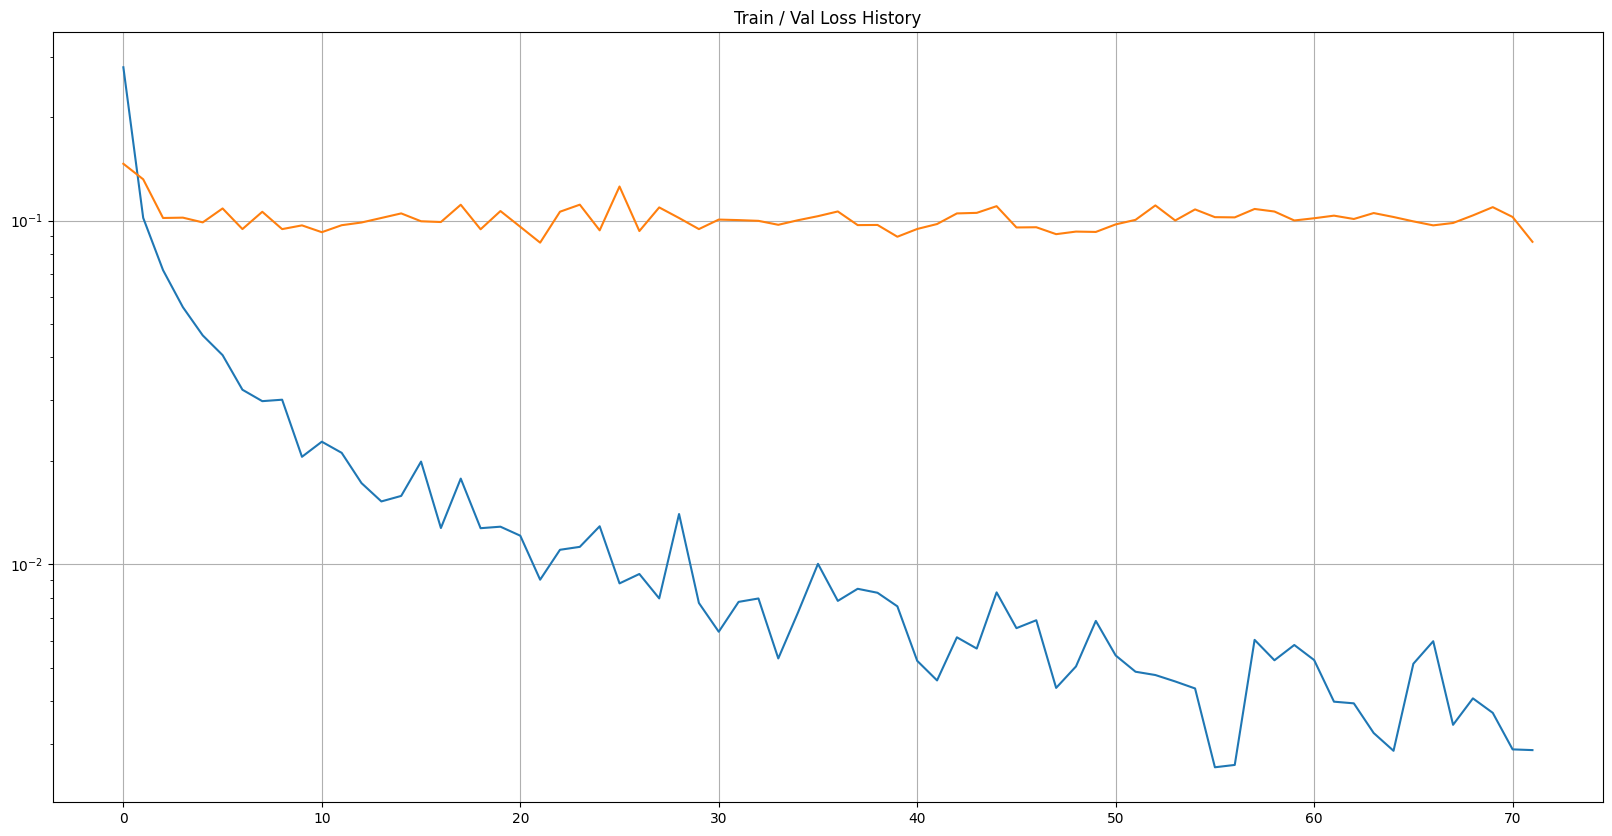

In [9]:
# 손실 곡선 시각화

plot_from = 0
train_plot = [float(t) for t in train_history]
val_plot = [float(v) for v in val_history]

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Val Loss History")

plt.plot(
    range(plot_from, len(train_plot)), train_plot[plot_from:],
    range(plot_from, len(val_plot)), val_plot[plot_from:]
)

plt.yscale('log')
plt.show()

In [10]:
# 테스트 평가

test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss
        y_hat += [y_hat_i]

test_loss /= len(x_)                # 평균 테스트 손실
y_hat = torch.cat(y_hat, dim=0)     # 전체 예측 결과 병합

# 가장 낮은 검증 손실 기준으로 출력
sorted_history = sorted(zip(train_history, val_history), key=lambda x: x[1])
print("Train loss: %.4e" % sorted_history[0][0])
print("Val loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 9.0183e-03
Val loss: 8.6292e-02
Test loss: 9.0031e-02


In [11]:
# 정확도 확인

correct_cnt = (y[2].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))

Test Accuracy: 0.9776


In [12]:
# 혼동행렬 그리기

pd.DataFrame(
    confusion_matrix(y[2].cpu(), torch.argmax(y_hat, dim=-1).cpu()),
    index=['true_%d' % i for i in range(10)],
    columns=['pred_%d' % i for i in range(10)]
)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,966,1,1,0,1,1,5,2,2,1
true_1,0,1121,3,3,0,5,1,1,1,0
true_2,4,2,1002,8,2,0,3,6,4,1
true_3,0,0,1,996,0,4,0,2,4,3
true_4,0,2,2,1,955,0,7,1,0,14
true_5,2,0,0,9,0,867,4,3,5,2
true_6,4,4,0,1,5,2,940,0,2,0
true_7,1,1,9,1,2,0,0,1008,1,5
true_8,8,1,2,2,2,6,2,2,940,9
true_9,2,2,1,5,9,3,0,3,3,981
